# FENICS SOLVER

### Import needed packages 

In [1]:
# Get the libraries
import fenics as fn
import numpy as np
import sympy as sym
import scipy as sc
from scipy import constants
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm #Colormap
import meshio as mio
#import mshr as msr

In [2]:
mesh = fn.Mesh()
with fn.XDMFFile("meshing/mesh.xdmf") as infile:
    infile.read(mesh)
mvc = fn.MeshValueCollection("size_t", mesh, 2) 
with fn.XDMFFile("meshing/mf.xdmf") as infile:
    infile.read(mvc, "name_to_read")
mf = fn.cpp.mesh.MeshFunctionSizet(mesh, mvc)


In [3]:
NX = 500
NY = NX
M    = 2   #species

Poly    = fn.FiniteElement('Lagrange', mesh.ufl_cell(),2)
Multi   = fn.FiniteElement('Real', mesh.ufl_cell(), 0)
ElemP   = [Poly] * (M+1) 
ElemR   = [Multi] * (M)
Elem    = [ElemP + ElemR][0]
Mixed   = fn.MixedElement(Elem)
V       = fn.FunctionSpace(mesh, Mixed)

In [4]:
# define potentials and concentrations
u_GND  = fn.Expression('0', degree=2)          #Ground
u_DD   = fn.Expression('5', degree=2)          #pontential
c_INIT = fn.Expression('0.01', degree=2)     #concentration on ground
c_avg  = fn.Expression('0.005', degree=2)    #average concentration

# define boundaries
def boundaryGND(x, on_boundary):
    tol=1e-12
    return ((x[1] < -400 + tol)) 
def boundaryHigh(x, on_boundary):
    tol=1e-12
    return (x[1] > pow(x[0]/5,2)  - tol)

# set boundary conditions
bcs = []
bcs += [fn.DirichletBC(V.sub(0), u_DD, mf, 1)]
bcs += [fn.DirichletBC(V.sub(0), u_GND, mf, 4)]
#bcs += [fn.DirichletBC(V.sub(i), c_INIT, mf, 1) for i in range(M+1)]


# define problem
UC    = fn.Function(V)
uc    = fn.split(UC)                        # trial function potential concentration lagrange multi
u, c, lam = uc[0], uc[1:M+1], uc[M+1:]

VW    = fn.TestFunctions(V)                          # test function potential concentration lagrange multi                     
v, w, mu = VW[0], VW[1:M+1], VW[M+1:]


#lets try rot
r = fn.Expression('x[0]', degree=0)

# changing concentrations charges
Rho = 0
for i in range(M):
    if i%2:
        Rho += -c[i]
    else:
        Rho += c[i]

PoissonLeft     = (fn.dot(fn.grad(u), fn.grad(v)))*fn.dx                    # weak solution Poisson left
PoissonRight    = -(Rho)*v*fn.dx                                  # weak solution Poisson right
NernstPlanck    = 0
for i in range(M):
    if i%2:
        NernstPlanck += fn.dot((-fn.grad(c[i]) + c[i]*fn.grad(u)),fn.grad(w[i]))*fn.dx     # weak solution Nernst-Planck 
    else:
        NernstPlanck += fn.dot((-fn.grad(c[i]) - c[i]*fn.grad(u)),fn.grad(w[i]))*fn.dx     # weak solution Nernst-Planck

constraint = 0
for i in range(M):
    constraint += lam[i] * w[i] * fn.dx + (c[i] - c_avg) * mu[i] * fn.dx            #constraint a la hoermann
    
        
PNP_xy     = PoissonLeft + PoissonRight + NernstPlanck + constraint        # PNP system
 

In [5]:
# Compute solution
fn.solve(PNP_xy == 0, UC, bcs) # solve function


In [6]:
S1, S2, S3, S4, S5 = UC.split()

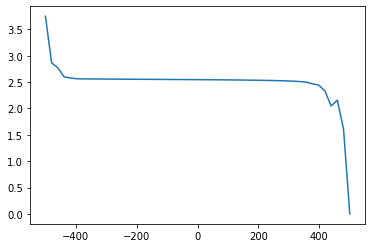

In [38]:

plt.plot(np.linspace(-500,500),[S1(0,x,0) for x in np.linspace(0,-500)])



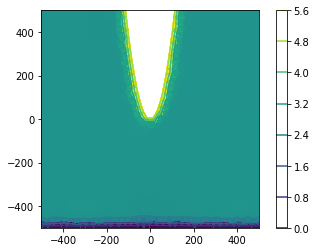

In [7]:
import matplotlib.tri as tri

def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:,0], xy[:,1], mesh.cells())

def plot(obj):
    plt.gca().set_aspect('equal')
    C = obj.compute_vertex_values(mesh)
    plt.tripcolor(mesh2triang(mesh), C, shading='flat')
    plt.tricontour(mesh2triang(mesh), C)
    plt.colorbar()

plot(S1)

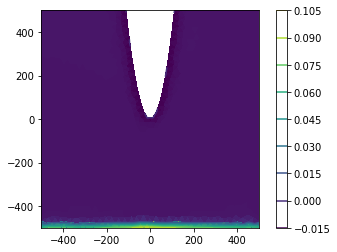

In [8]:
plot(S2)

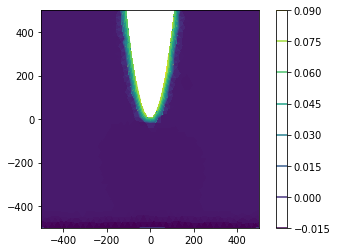

In [9]:
plot(S3)